In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
import sys
sys.path.append('..')
import utils
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuasegal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/joshuasegal/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/joshuasegal/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Define the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Define the data directory path
data_dir = os.path.join(parent_dir, 'data', 'text_entailment_dataset')

# Define file paths
train_csv_path = os.path.join(data_dir, 'train.csv')
train_data_csv_path = os.path.join(data_dir, 'train_data.csv')
validation_data_csv_path = os.path.join(data_dir, 'validation_data.csv')
test_data_csv_path = os.path.join(data_dir, 'test_data.csv')

# Read the CSV file into a DataFrame
df = pd.read_csv(train_csv_path)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

# Further split training set into train and test subsets
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Write the training and validation DataFrames to separate CSV files
train_df.to_csv(train_data_csv_path, index=False)
validation_df.to_csv(validation_data_csv_path, index=False)
test_df.to_csv(test_data_csv_path, index=False)

# Read datasets from CSV files
train_dataset = pd.read_csv(train_data_csv_path)
validation_dataset = pd.read_csv(validation_data_csv_path)
test_dataset = pd.read_csv(test_data_csv_path)

In [3]:
train_dataset.head()

,premise,hypothesis,label
0,Four guys sitting around a table with two cand...,Four guys are at a church service.,2
1,a little boy using a drill to make a hole in a...,The little boy is using a tool.,0
2,People go by old white walls with gray squares.,Males and females are in proximity of old walls.,0
3,About eight women in purple and blue dresses b...,About eight women in purple and blue dresses.,0
4,Customers are standing in line to buy somethin...,The customers leave the store after a satisfac...,2


In [4]:
train_dataset.shape

(351590, 3)

In [5]:
validation_dataset.head()

,premise,hypothesis,label
0,A young couple looking at different types and ...,a couple is looking,0
1,A man in a purple had climbs a rocky wall with...,A man is going to the temple.,2
2,A group of friends playing cards and trying to...,The people are playing a card game.,0
3,People looking at fish at an aquarium.,People looking at fish.,0
4,An older lady blowing out a 9 and a 0 number c...,A woman drinks coffee while driving.,2


In [6]:
validation_dataset.shape

(109873, 3)

In [7]:
test_dataset.head()

,premise,hypothesis,label
0,A quarterback is looking to set up a pass from...,the men are playing football,0
1,A woman speaking her mind.,A woman talking.,0
2,Woman in a blue jacket sitting at the edge of ...,A woman is at home,2
3,A man stands next to a lady with a dog hat.,A man stands next to a strange homeless lady w...,1
4,A man is vending an assortment of hats.,a man sells hats,0


In [8]:
test_dataset.shape

(87898, 3)

In [9]:
train_dataset[["premise"]] = train_dataset[["premise"]].astype(str)
train_dataset["premise"] = train_dataset["premise"].apply(utils.change_lower)
train_dataset["premise"] = train_dataset["premise"].apply(utils.clean_data)
train_dataset["premise"] = train_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = train_dataset[["hypothesis"]].astype(str)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.change_lower)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.clean_data)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.remover)

validation_dataset[["premise"]] = validation_dataset[["premise"]].astype(str)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.change_lower)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.clean_data)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.remover)

validation_dataset[["hypothesis"]] = validation_dataset[["hypothesis"]].astype(str)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.change_lower)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.clean_data)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.remover)

test_dataset[["premise"]] = test_dataset[["premise"]].astype(str)
test_dataset["premise"] = test_dataset["premise"].apply(utils.change_lower)
test_dataset["premise"] = test_dataset["premise"].apply(utils.clean_data)
test_dataset["premise"] = test_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = test_dataset[["hypothesis"]].astype(str)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.change_lower)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.clean_data)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.remover)

In [10]:
# Combine text data from training and validation datasets
text_data_train = train_dataset['premise'] + ' ' + train_dataset['hypothesis']
text_data_validation = validation_dataset['premise'] + ' ' + validation_dataset['hypothesis']
text_data_test = test_dataset['premise'] + ' ' + test_dataset['hypothesis']

# Concatenate both training and validation text data
text_data_combined = pd.concat([text_data_train, text_data_validation], ignore_index=True)

In [11]:
vectorizer = CountVectorizer() # add max features ?
X = vectorizer.fit(text_data_combined)

In [12]:
X_train = vectorizer.fit_transform(text_data_train)
X_validation = vectorizer.transform(text_data_validation)

In [13]:
import pickle

# Save the vectorizer to a file
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [14]:
# Extract labels for train data
y_train = train_dataset['label']

# Extract labels for validation data
y_validation = validation_dataset['label']

In [15]:

# Define hyperparameters for testing L1 and L2 regularization
hyperparameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1],
    'solver': ['liblinear', 'lbfgs']
}

# Initialize lists to store results
results = []

# Test both L1 and L2 regularization
for penalty in hyperparameters['penalty']:
    for C in hyperparameters['C']:
        for solver in hyperparameters['solver']:
            if solver == 'lbfgs' and penalty == 'l1':
                continue
            # Initialize logistic regression model with specified penalty and C
            logistic_model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=10000)

            # Train the model
            logistic_model.fit(X_train, y_train)

            # Predict on the validation set
            y_pred = logistic_model.predict(X_validation)

            # Evaluate accuracy
            accuracy = accuracy_score(y_validation, y_pred)

            # Store results
            results.append({
                'penalty': penalty,
                'C': C,
                'accuracy': accuracy,
                'solver': solver
            })

# Print results
for result in results:
    print("Penalty: {}, C: {}, Solver: {}, Accuracy: {:.4f}".format(result['penalty'], result['C'], result['solver'], result['accuracy']))

Penalty: l1, C: 0.1, Solver: liblinear, Accuracy: 0.5233
Penalty: l1, C: 1, Solver: liblinear, Accuracy: 0.5262
Penalty: l2, C: 0.1, Solver: liblinear, Accuracy: 0.5246
Penalty: l2, C: 0.1, Solver: lbfgs, Accuracy: 0.5233
Penalty: l2, C: 1, Solver: liblinear, Accuracy: 0.5182
Penalty: l2, C: 1, Solver: lbfgs, Accuracy: 0.5143


In [16]:
text_data_train[0]

'four guys sitting around table two candles glasses full beer four guys church service'

In [17]:
text_data_train.shape

(351590,)

In [18]:
text_data_validation.shape

(109873,)

In [19]:
# Initialize lists to store metric values for each iteration
precision_values = []
recall_values = []
accuracy_values = []
f1_score_values = []

# Assuming you have your full dataset stored in X and y
# Splitting the data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Initialize the logistic regression model
log_reg = LogisticRegression(penalty='l1', C=1, solver='liblinear')

best_f1_score = 0
best_model = None

# Assuming you have a loop for multiple iterations (e.g., epochs)
for i in range(10):  # num_iterations is the number of iterations in your loop
    # Incrementally increase the size of the training data
    train_size = int((i + 1) * 0.1 * X_train.shape[0])
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]

    # Fit the model to the training data subset
    log_reg.fit(X_train_subset, y_train_subset)

    # Make predictions on the validation data
    y_pred = log_reg.predict(X_validation)

    # Calculate precision, recall, accuracy, and F1-score
    precision = precision_score(y_validation, y_pred, average='weighted')
    recall = recall_score(y_validation, y_pred, average='weighted')
    accuracy = accuracy_score(y_validation, y_pred)
    f1 = f1_score(y_validation, y_pred, average='weighted')

    # Append the calculated values to the lists
    precision_values.append(precision)
    recall_values.append(recall)
    accuracy_values.append(accuracy)
    f1_score_values.append(f1)

    # Check if the current model is the best based on F1-score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = log_reg

# Save the best model
joblib.dump(best_model, 'best_logistic_regression_model.pkl')


['best_logistic_regression_model.pkl']

In [21]:
# Predict probabilities on the test set
y_pred = log_reg.predict(X_test)

# Calculate performance metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Final Test Accuracy:", accuracy)
print("Final Test Precision:", precision)
print("Final Test Recall:", recall)
print("Final Test F1 Score:", f1)

Final Test Accuracy: 0.5260957365112774
Final Test Precision: 0.5298795848628819
Final Test Recall: 0.5260957365112774
Final Test F1 Score: 0.5243841913444597


In [22]:
X_train.shape

(316431, 31257)

In [23]:
print(precision)
print(recall)
print(accuracy)
print(f1)

0.5298795848628819
0.5260957365112774
0.5260957365112774
0.5243841913444597


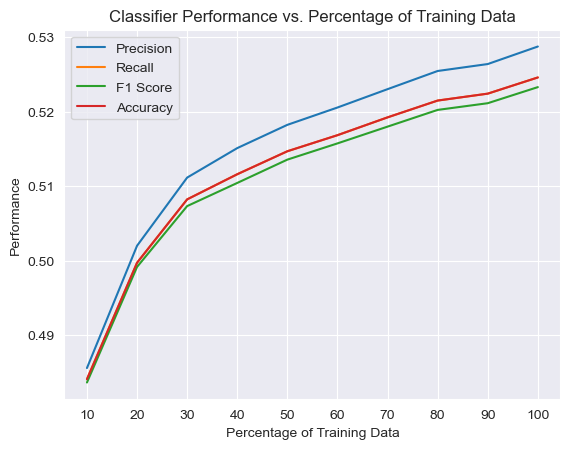

In [24]:
percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.plot(percents, precision_values, label='Precision')
plt.plot(percents, recall_values, label='Recall')
plt.plot(percents, f1_score_values, label='F1 Score')
plt.plot(percents, accuracy_values, label='Accuracy')

plt.xlabel('Percentage of Training Data')
plt.ylabel('Performance')
plt.title('Classifier Performance vs. Percentage of Training Data')
plt.xticks(percents)
plt.legend()

plt.savefig("logistic_regression.jpg")
plt.show()